## Homogenous (stationary) Markov Chain Implementation in Edward

### Package Imports and Options

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
import edward as ed
from edward.models import Bernoulli, Categorical, Normal, Empirical, Multinomial

from utils.utils import load_dataframe, load_data_dic, preprocess

Instructions for updating:
Use the retry module or similar alternatives.


In [6]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)
sns.set_style('whitegrid')

### Load Data

In [9]:
df_raw = load_dataframe()

Loading raw data from csv...
Fetching and caching raw data took 128.84 seconds
id             int64   
loan_status    category
age_of_loan    int64   
term           category
dtype: object
Retrieved 40,263,987 rows, 4 columns


In [10]:
df = df_raw.copy()

### Analysis

In [11]:
counts = df.groupby(['term', 'age_of_loan', 'loan_status']).count()

In [13]:
counts.head(20)

id
term age_of_loan loan_status                  
36   0           Charged Off        NaN       
                 Current             4352.0   
                 Default            NaN       
                 Fully Paid          11514.0  
                 In Grace Period    NaN       
                 Issued              18937.0  
                 Late (16-30 days)  NaN       
                 Late (31-120 days) NaN       
     1           Charged Off         13.0     
                 Current             1491702.0
                 Default            NaN       
                 Fully Paid          13071.0  
                 In Grace Period     87.0     
                 Issued              3.0      
                 Late (16-30 days)   2238.0   
                 Late (31-120 days)  1313.0   
     2           Charged Off         53.0     
                 Current             1448461.0
                 Default            NaN       
                 Fully Paid          13369.0

In [7]:
# get currently active loans
df_active = df.loc[df.age_of_loan < df.term.astype(int)].reset_index(drop=True)
df_inactive = df.loc[~(df.age_of_loan < df.term.astype(int))].reset_index(drop=True)
df_active.shape[0] + df_inactive.shape[0] == df.shape[0]

True

In [8]:
df_active.shape

(40061995, 4)

In [9]:
df_inactive.shape

(206599, 4)

In [12]:
df_active.dtypes

id             int64   
loan_status    category
age_of_loan    int64   
term           category
dtype: object

/Users/basilvetas/.local/share/virtualenvs/lending-club-analysis-iUojZaP3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


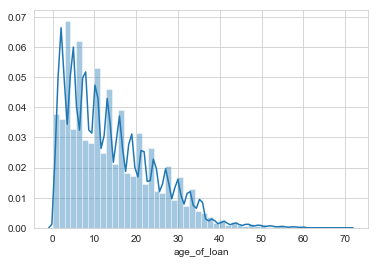

In [13]:
sns.distplot(df.age_of_loan)

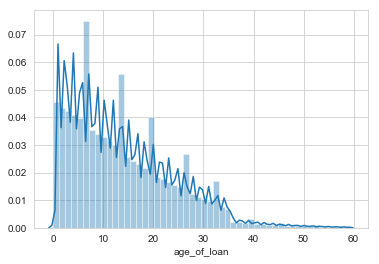

In [14]:
sns.distplot(df_active.age_of_loan)

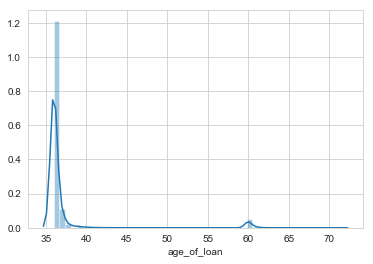

In [15]:
sns.distplot(df_inactive.age_of_loan)

In [19]:
# split active loans by 36 and 60 month terms
df_active_36 = df_active.loc[df_active.term.astype(int) == 36]
df_active_60 = df_active.loc[df_active.term.astype(int) == 60]
df_active_36.shape[0] + df_active_60.shape[0] == df_active.shape[0]

True

In [20]:
df_active_36.shape

(27466244, 4)

In [21]:
df_active_60.shape

(12595751, 4)

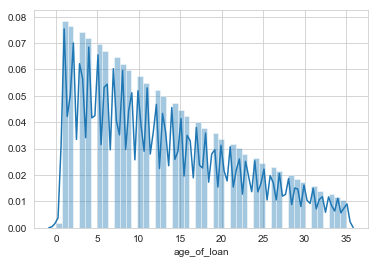

In [22]:
sns.distplot(df_active_36.age_of_loan)

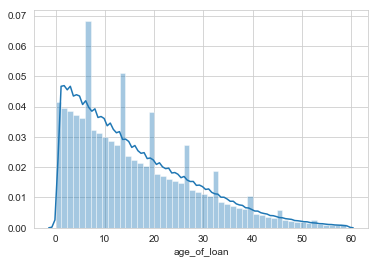

In [23]:
sns.distplot(df_active_60.age_of_loan)

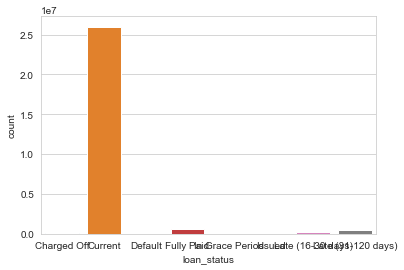

In [24]:
sns.countplot(x="loan_status", data=df_active_36)

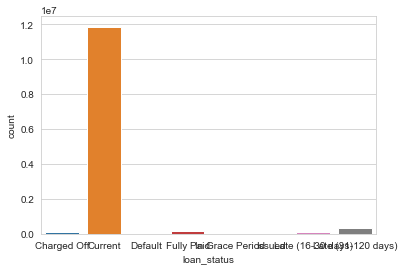

In [25]:
sns.countplot(x="loan_status", data=df_active_60)

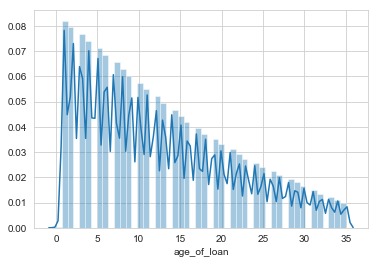

In [26]:
sns.distplot(df_active_36.loc[df_active_36.loan_status == 'Current'].age_of_loan)

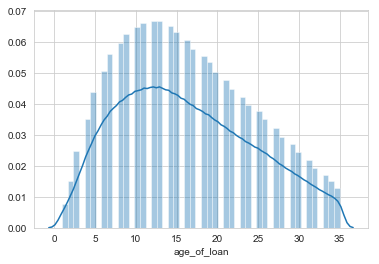

In [38]:
late = (df_active_36.loan_status == 'Late (16-30 days)') | (df_active_36.loan_status == 'Late (31-120 days)')
sns.distplot(df_active_36.loc[late].age_of_loan)

### Preprocessing

In [14]:
df = preprocess(df)

Preprocessing data...
Preprocessing and caching took 55.59 seconds
Preprocessed 40,263,987 rows, 4 columns


In [15]:
df.term.value_counts()

0    27659388
1    12604599
Name: term, dtype: int64

In [16]:
df.loan_status.value_counts(sort=False)

0    234296  
1    37859913
2    49490   
3    951255  
4    10233   
5    22905   
6    292358  
7    843537  
Name: loan_status, dtype: int64

**TODO** it might be good to use panda's Categorical type instead of sklearn's label encoder so we have the mapping between indew and category directly from the dataframe (or modify the preprocess function to return the label encoder objects too, but then it means we also need to cache them which is not super clean).

## Markov chain

### Generating the transitions

This doesn't take too long (took me a while to figure out a clean way to do it):

In [116]:
df['previous_month'] = df.age_of_loan - 1
transitions =  pd.merge(df, df, left_on=['id', 'age_of_loan'], right_on=['id', 'previous_month'])

In [117]:
transitions.head()

,id,loan_status_x,age_of_loan_x,term_x,previous_month_x,loan_status_y,age_of_loan_y,term_y,previous_month_y
0,54734,1,1,0,0,1,2,0,1
1,54734,1,2,0,1,1,3,0,2
2,54734,1,3,0,2,1,4,0,3
3,54734,1,4,0,3,1,5,0,4
4,54734,1,5,0,4,1,6,0,5


### Solving with MLE:

The MLE solution to a markov chain is simply the empirical counts, so easy to implement. This can give us a good baseline to check our bayesian results later:

**Step 1**: count the transitions

In [211]:
transition_counts = pd.crosstab(transitions['loan_status_x'],
                                transitions['loan_status_y'])

**Step 2**: transform the count dataframe to a count matrix:

In [212]:
transition_counts

loan_status_y,0,1,2,3,4,6,7
loan_status_x,,,,,,,
1,1245,35679469,4,898628,9517,260336,96651
2,45449,220,2861,135,0,5,770
3,0,0,0,12119,18,169,96
4,0,436,0,15,28,96,64
5,0,20644,0,852,2,64,1
6,7354,49741,0,3462,459,23156,198158
7,180232,38013,46625,3840,83,5512,546017


Note that row 0 is missing, we add it by hand and set it to 0. Same with column 5:

In [213]:
for i in range(n_statuses):
    if i not in transition_counts.index:
        # if no row, create it and set to 0:
        print('Filling in row %s ...' % (i,))
        transition_counts.loc[i] = 0
    if i not in transition_counts.columns:
        # if no column, create it and set to 0:
        print('Filling in column %s ...' % (i,))
        transition_counts[i] = 0

Filling in row 0 ...
Filling in column 5 ...


In [214]:
transition_counts

loan_status_y,0,1,2,3,4,6,7,5
loan_status_x,,,,,,,,
1,1245,35679469,4,898628,9517,260336,96651,0
2,45449,220,2861,135,0,5,770,0
3,0,0,0,12119,18,169,96,0
4,0,436,0,15,28,96,64,0
5,0,20644,0,852,2,64,1,0
6,7354,49741,0,3462,459,23156,198158,0
7,180232,38013,46625,3840,83,5512,546017,0
0,0,0,0,0,0,0,0,0


Re-sort the indexes:

In [215]:
transition_counts.sort_index(axis=0, inplace=True)
transition_counts.sort_index(axis=1, inplace=True)

In [216]:
transition_counts

loan_status_y,0,1,2,3,4,5,6,7
loan_status_x,,,,,,,,
0,0,0,0,0,0,0,0,0
1,1245,35679469,4,898628,9517,0,260336,96651
2,45449,220,2861,135,0,0,5,770
3,0,0,0,12119,18,0,169,96
4,0,436,0,15,28,0,96,64
5,0,20644,0,852,2,0,64,1
6,7354,49741,0,3462,459,0,23156,198158
7,180232,38013,46625,3840,83,0,5512,546017


Note with crosstab we could have gotten the frequencies directly, but having this raw count table might be useful for the Bayesian case.

We can also get the margins directly (sum by row), but then sort_index fails...

In [158]:
transitions_mle = transition_counts.values.astype(float)

In [159]:
for i in range(transitions_mle.shape[0]):
    n_i_all = sum(transitions_mle[i,:]) # count how many i => j for this i and any j
    if n_i_all != 0:
        transitions_mle[i,:] *= (1/n_i_all)

In [162]:
np.round(transitions_mle, 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.97, 0.  , 0.02, 0.  , 0.  , 0.01, 0.  ],
       [0.92, 0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.02],
       [0.  , 0.  , 0.  , 0.98, 0.  , 0.  , 0.01, 0.01],
       [0.  , 0.68, 0.  , 0.02, 0.04, 0.  , 0.15, 0.1 ],
       [0.  , 0.96, 0.  , 0.04, 0.  , 0.  , 0.  , 0.  ],
       [0.03, 0.18, 0.  , 0.01, 0.  , 0.  , 0.08, 0.7 ],
       [0.22, 0.05, 0.06, 0.  , 0.  , 0.  , 0.01, 0.67]])

### Bayesian Estimation:

In [163]:
import tensorflow as tf
import edward as ed

**Based on the paper "Markov Chain Models for Delinquency: Transition Matrix Estimation and Forecasting", Scott D. Grimshaw, William P. Alexander, Section 3**

We can model the counts of the transitions with a multinomial. More specifically:

We call $f(j)$ the row vector of monthly movements: $f(j,k)$ is the number of accounts that start the month in state $j$ and move to state $k$. We model this vector's distribution as a multinomial.

The multinomial follows probabilities, denoted as $p(j,k)$ in the paper, that are the probability of each individual transition j => k.

And the prior is the Dirichlet distribution with parameters $\alpha(j)$.

In [172]:
transition_counts.iloc[1,:].values

array([    1245, 35679469,        4,   898628,     9517,        0,
         260336,    96651])

**Transition counts, per month:**

In [192]:
transitions.head()

,id,loan_status_x,age_of_loan_x,term_x,previous_month_x,loan_status_y,age_of_loan_y,term_y,previous_month_y
0,54734,1,1,0,0,1,2,0,1
1,54734,1,2,0,1,1,3,0,2
2,54734,1,3,0,2,1,4,0,3
3,54734,1,4,0,3,1,5,0,4
4,54734,1,5,0,4,1,6,0,5


In [195]:
transition_counts_per_month = transitions.groupby(['previous_month_x', 'loan_status_x', 'loan_status_y']).size()

In [209]:
temp = list()
for month in transition_counts_per_month.index.levels[0]:
    temp.append(transition_counts_per_month[month].unstack().fillna(0))
transition_counts_per_month = temp

In [210]:
transition_counts_per_month[0]

loan_status_y,1,3,4,6,7
loan_status_x,,,,,
1,5162.0,219.0,1.0,8.0,21.0
3,0.0,48.0,0.0,1.0,0.0
5,20644.0,852.0,2.0,64.0,1.0


In [223]:
for counts in transition_counts_per_month:
    for i in range(n_statuses):
        if i not in counts.index:
            # if no row, create it and set to 0:
            # print('Filling in row %s ...' % (i,))
            counts.loc[i] = 0
        if i not in counts.columns:
            # if no column, create it and set to 0:
            # print('Filling in column %s ...' % (i,))
            counts[i] = 0
    counts.sort_index(axis=0, inplace=True)
    counts.sort_index(axis=1, inplace=True)

In [224]:
transition_counts_per_month[0]

loan_status_y,0,1,2,3,4,5,6,7
loan_status_x,,,,,,,,
0,0,0.0,0,0.0,0.0,0,0.0,0.0
1,0,5162.0,0,219.0,1.0,0,8.0,21.0
2,0,0.0,0,0.0,0.0,0,0.0,0.0
3,0,0.0,0,48.0,0.0,0,1.0,0.0
4,0,0.0,0,0.0,0.0,0,0.0,0.0
5,0,20644.0,0,852.0,2.0,0,64.0,1.0
6,0,0.0,0,0.0,0.0,0,0.0,0.0
7,0,0.0,0,0.0,0.0,0,0.0,0.0


In [181]:
n_accounts = df.id.nunique()

In [182]:
n_accounts

2131441

In [30]:
# code from edward/examples/dirichlet_categorical.py:
# Inferring a categorical distribution with KLqp
tf.reset_default_graph()
sess = tf.InteractiveSession()
K = 4
N = 30
# DATA
pi_true = np.random.dirichlet(np.array([20.0, 30.0, 10.0, 10.0]))
z_data = np.array([np.random.choice(K, 1, p=pi_true)[0]
                   for n in range(N)])
print("pi: {}".format(pi_true))

# MODEL
pi = ed.models.Dirichlet(tf.ones(4))
z = ed.models.Categorical(probs=pi, sample_shape=N)

# INFERENCE
qpi = ed.models.Dirichlet(tf.nn.softplus(
    tf.get_variable("qpi/concentration", [K])))

inference = ed.KLqp({pi: qpi}, data={z: z_data})
inference.run(n_iter=1500, n_samples=30)

# sess = ed.get_session()
print("Inferred pi: {}".format(sess.run(qpi.mean())))

pi: [0.29418064 0.4567149  0.16900305 0.08010142]
1500/1500 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 43.554
Inferred pi: [0.24911399 0.25168204 0.2989325  0.20027141]


In [33]:
z_data

array([3, 0, 2, 0, 0, 1, 3, 0, 3, 2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 1, 0, 3,
       1, 1, 1, 2, 1, 3, 2, 0])

In [74]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

data = np.array([month_counts.iloc[2,:].values for month_counts in transition_counts_per_month])

# MODEL
# trying to build a model just for the first row:
pi = ed.models.Dirichlet(tf.ones(n_statuses))
qpi = ed.models.Dirichlet(tf.nn.softplus(tf.get_variable("qpi/concentration", [n_statuses])), name="qpi")

# TODO define counts for each row
# (since there aren't too many rows we can just do a loop instead of using a matrix)
# total_count is the number of individual draws for each sample of the multinomial
counts = ed.models.Multinomial(total_count=data.sum(axis=1).astype(np.float32), probs=pi)

# INFERENCE
inference = ed.KLqp({pi: qpi}, data={counts: data}) # TODO check other inferences
inference.run(n_iter=500)
# n_samples = Number of samples from variational model for calculating stochastic gradients.
# left to 1 for now... not sure

# CRITICISM
print("Inferred pi: {}".format(sess.run(qpi.mean())))

500/500 [100%] ██████████████████████████████ Elapsed: 1s | Loss: nan
Inferred pi: [nan nan nan nan nan nan nan nan]


Fails... Not sure if it's because we're using VI or for other reasons...

Same but with other inference:

This fails, the error is related to https://github.com/blei-lab/edward/issues/785.
I think the error is linked to the fact that dirichlet is actually defined in a k-1 dimensional space (because vectors need to sum up to 1).

In Edward MCMC requires that latent vars have "unconstrained support" (see edward/inferences/hmc.py). They say that setting auto_transform=True should make the vars unconstrained and fix the problem...

About auto_transform: *Automated transformations provide convenient handling of constrained continuous variables during inference by transforming them to an unconstrained space. Automated transformations are crucial for expanding the scope of algorithm classes such as gradient-based Monte Carlo and variational inference with reparameterization gradients.*

But it doesn't seem to work...

In [85]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

data = np.array([month_counts.iloc[1,:].values for month_counts in transition_counts_per_month])

# MODEL
# trying to build a model just for the first row:
pi = ed.models.Dirichlet(tf.ones(n_statuses))
counts = ed.models.Multinomial(total_count=data.sum(axis=1).astype(np.float32), probs=pi)

# INFERENCE with HMC = "black box" Monte Carlo
# note you can't call ed.MonteCarlo directly in Edward, it's an abstract class (for all variants of MCMC)
T = 5000 # number of posterior samples => I think this is the "M" in our lecture on MCMC,
# i.e. length of the MC used for the inference, so shouldn't be the number of samples that we have
# but not sure about that...

# the approximating family has to be an empirical distribution in MCMC:
qpi = ed.models.Empirical(params=tf.get_variable("qpi/params", [T, n_statuses],
      initializer=tf.constant_initializer(1.0 / n_statuses))) # initialize as uniform probs

inference = ed.inferences.HMC({pi: qpi}, data={counts: data}, auto_transform=True)
inference.run(step_size=1e-3) # set n_samples=?

# CRITICISM
print("Inferred pi: {}".format(sess.run(qpi.mean()))) 

TypeError: __init__() got an unexpected keyword argument 'auto_transform'

In [82]:
# example from examples/bayesian_linear_regression_sghmc.py
tf.reset_default_graph()
sess = tf.InteractiveSession()
def build_toy_dataset(N, noise_std=0.5):
    X = np.concatenate([np.linspace(0, 2, num=N / 2),
                        np.linspace(6, 8, num=N / 2)])
    y = 2.0 * X + 10 * np.random.normal(0, noise_std, size=N)
    X = X.astype(np.float32).reshape((N, 1))
    y = y.astype(np.float32)
    return X, y

N = 40  # number of data points
D = 1  # number of features
# DATA
X_train, y_train = build_toy_dataset(N)
X_test, y_test = build_toy_dataset(N)

# MODEL
X = tf.placeholder(tf.float32, [N, D])
w = ed.models.Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = ed.models.Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = ed.models.Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))

# INFERENCE
T = 5000                        # Number of samples.
nburn = 100                     # Number of burn-in samples.
stride = 10                     # Frequency with which to plot samples.
qw = ed.models.Empirical(params=tf.Variable(tf.random_normal([T, D])))
qb = ed.models.Empirical(params=tf.Variable(tf.random_normal([T, 1])))

inference = ed.SGHMC({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(step_size=1e-3)

/Users/jeromekafrouni/.pyenv/versions/3.6.1/envs/prob-prog/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """
/Users/jeromekafrouni/.pyenv/versions/3.6.1/envs/prob-prog/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


5000/5000 [100%] ██████████████████████████████ Elapsed: 6s | Acceptance Rate: 1.000
